This notebook is to visualize the results of the local source (LS) and Breezometer (BRZ) fire polygon intersection analysis.

In [1]:
from brz_storage_lib.download import Download
from datetime import datetime, timedelta
from shapely.validation import make_valid
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.wkt import loads

import pandas as pd
import pandas_gbq
import geopandas as gpd
import os
import fiona
import io
import json
import itertools

# for progress monitoring
import tqdm
from tqdm import tqdm

# for data plotting / mapping / exploring
import folium
import matplotlib
import mapclassify

# for BQ query (for BRZ fire polygons)
from geopandas import GeoDataFrame
from google.cloud import bigquery

# class to extend JSON encoder to convert timestamp columns to string values
class PdEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, pd.Timestamp):
            return str(obj)
        return json.JSONEncoder.default(self, obj)
    
# for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
# Import natural earth data for plot overlays

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

2022-11-03 14:09:34,676 [ERROR]  PROJ: proj_identify: /opt/conda/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2022-11-03 14:09:34,678 [INFO]  Failed to auto identify EPSG: 7




[gdf_LS_BRZ_no_intersection type]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_BRZ_no_intersection.is_valid]:
True

[gdf_LS_BRZ_no_intersection]:
     UniqueSourceEventId  SourceId           SourceName  \
0          BC_CAN_N11064    BC_CAN  BC_Wildfire_Service   
1          BC_CAN_N12113    BC_CAN  BC_Wildfire_Service   
2          BC_CAN_N40903    BC_CAN  BC_Wildfire_Service   
3          BC_CAN_N41683    BC_CAN  BC_Wildfire_Service   
4          BC_CAN_N41684    BC_CAN  BC_Wildfire_Service   
...                  ...       ...                  ...   
1022     WAFS_AUS_590319  WAFS_AUS         Emergency WA   
1023     WAFS_AUS_590296  WAFS_AUS         Emergency WA   
1024     WAFS_AUS_590291  WAFS_AUS         Emergency WA   
1025     WAFS_AUS_590011  WAFS_AUS         Emergency WA   
1026     WAFS_AUS_589659  WAFS_AUS         Emergency WA   

                                       SourceURL SourceEventId  \
0        https://www2.gov.bc.ca/gov/content/home        N11064   


<AxesSubplot:>

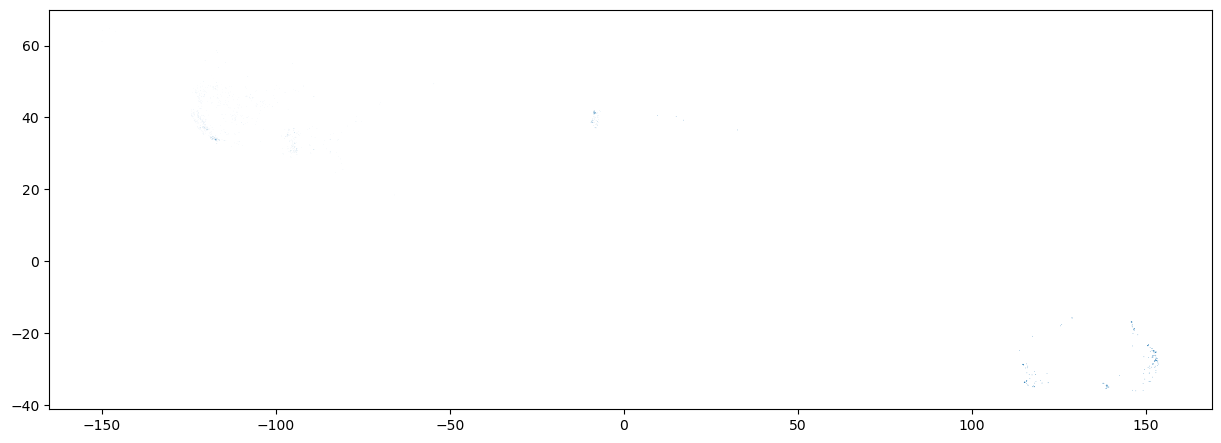

In [14]:
# Load 'no intersection' gpkg to GeoDataFrame for all files

gdf_LS_BRZ_no_intersection = []

gdf_LS_BRZ_no_intersection = gpd.read_file("gdf_LS_BRZ_no_intersection_2022-10-01T00:00:00_2022-10-02T00:00:00.gpkg")

gdf_LS_BRZ_no_intersection.set_geometry('geometry', drop=False, inplace=False, crs=4326)

print('\n\n[gdf_LS_BRZ_no_intersection type]:')
print(type(gdf_LS_BRZ_no_intersection))
print('\n[gdf_LS_BRZ_no_intersection.is_valid]:')
print(gdf_LS_BRZ_no_intersection.is_valid.all())
print('\n[gdf_LS_BRZ_no_intersection]:')
print(gdf_LS_BRZ_no_intersection)

# create a plot of the GDF
gdf_LS_BRZ_no_intersection.plot(figsize=(15,15))

In [15]:
# Calculate centroids for map display for 'no intersection' GDF

# In order to properly compute geometric properties, in this case centroids, of the geometries, we need to project the data to a projected coordinate system.
# Project to Google Maps Global Mercator -- Spherical Mercator projected crs
gdf_LS_BRZ_no_intersection = gdf_LS_BRZ_no_intersection.to_crs(epsg=900913)

# Access the centroid attribute of each polygon
gdf_LS_BRZ_no_intersection['centroid'] = gdf_LS_BRZ_no_intersection.centroid

# Since we’re again adding a new geometry to the Folium map, we need to project the geometry back to a geographic coordinate system with latitude and longitude values.
# Project to WGS84 geographic crs

# geometry (active) column
gdf_LS_BRZ_no_intersection = gdf_LS_BRZ_no_intersection.to_crs(epsg=4326)

# Centroid column
gdf_LS_BRZ_no_intersection['centroid'] = gdf_LS_BRZ_no_intersection['centroid'].to_crs(epsg=4326)

print('\n\n[gdf_LS_BRZ_no_intersection type - after centroid addition]:')
print(type(gdf_LS_BRZ_no_intersection))
print('\n[gdf_LS_BRZ_no_intersection.is_valid - after centroid addition]:')
print(gdf_LS_BRZ_no_intersection.is_valid.all())
print('\n[gdf_LS_BRZ_no_intersection - after centroid addition]:')
print(gdf_LS_BRZ_no_intersection)




[gdf_LS_BRZ_no_intersection type - after centroid addition]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_BRZ_no_intersection.is_valid - after centroid addition]:
True

[gdf_LS_BRZ_no_intersection - after centroid addition]:
     UniqueSourceEventId  SourceId           SourceName  \
0          BC_CAN_N11064    BC_CAN  BC_Wildfire_Service   
1          BC_CAN_N12113    BC_CAN  BC_Wildfire_Service   
2          BC_CAN_N40903    BC_CAN  BC_Wildfire_Service   
3          BC_CAN_N41683    BC_CAN  BC_Wildfire_Service   
4          BC_CAN_N41684    BC_CAN  BC_Wildfire_Service   
...                  ...       ...                  ...   
1022     WAFS_AUS_590319  WAFS_AUS         Emergency WA   
1023     WAFS_AUS_590296  WAFS_AUS         Emergency WA   
1024     WAFS_AUS_590291  WAFS_AUS         Emergency WA   
1025     WAFS_AUS_590011  WAFS_AUS         Emergency WA   
1026     WAFS_AUS_589659  WAFS_AUS         Emergency WA   

                                       SourceURL Sourc



[gdf_LS_BRZ_intersection type]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_BRZ_intersection.is_valid]:
True

[gdf_LS_BRZ_intersection]:
    UniqueSourceEventId SourceId_LS                            SourceName_LS  \
0      EFFIS_EU_1504507    EFFIS_EU  European Forest Fire Information System   
1      EFFIS_EU_1504507    EFFIS_EU  European Forest Fire Information System   
2      EFFIS_EU_1504507    EFFIS_EU  European Forest Fire Information System   
3      EFFIS_EU_1504320    EFFIS_EU  European Forest Fire Information System   
4      EFFIS_EU_1503803    EFFIS_EU  European Forest Fire Information System   
..                  ...         ...                                      ...   
814     WAFS_AUS_589832    WAFS_AUS                             Emergency WA   
815     WAFS_AUS_589832    WAFS_AUS                             Emergency WA   
816     WAFS_AUS_589832    WAFS_AUS                             Emergency WA   
817     WAFS_AUS_589832    WAFS_AUS               

<AxesSubplot:>

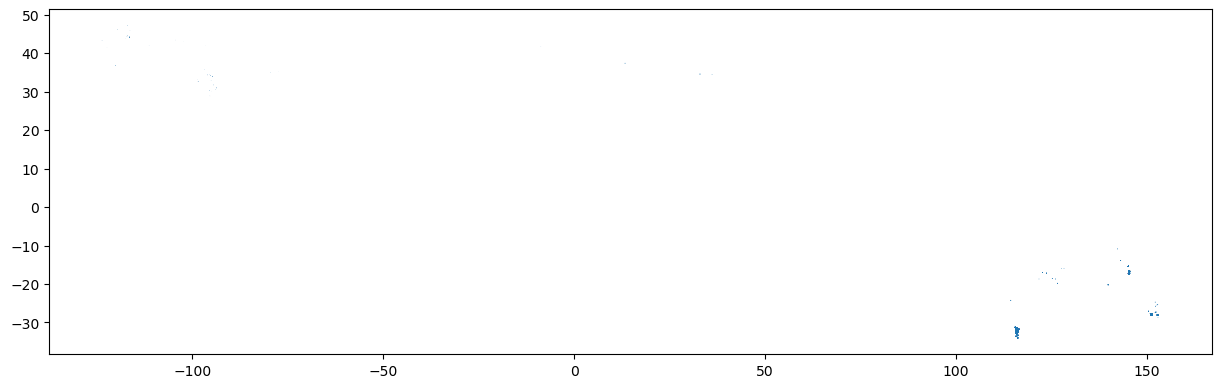

In [16]:
# Load intersection gpkg to GeoDataFrame for all files

gdf_LS_BRZ_intersection = []

gdf_LS_BRZ_intersection = gpd.read_file("gdf_LS_BRZ_intersection_2022-10-01T00:00:00_2022-10-02T00:00:00.gpkg")

gdf_LS_BRZ_intersection.set_geometry('geometry', drop=False, inplace=False, crs=4326)

print('\n\n[gdf_LS_BRZ_intersection type]:')
print(type(gdf_LS_BRZ_intersection))
print('\n[gdf_LS_BRZ_intersection.is_valid]:')
print(gdf_LS_BRZ_intersection.is_valid.all())
print('\n[gdf_LS_BRZ_intersection]:')
print(gdf_LS_BRZ_intersection)

# create a plot of the GDF
gdf_LS_BRZ_intersection.plot(figsize=(15,15))

In [17]:
# Calculate centroids for map display for 'intersection' GDF

# In order to properly compute geometric properties, in this case centroids, of the geometries, we need to project the data to a projected coordinate system.
# Project to Google Maps Global Mercator -- Spherical Mercator projected crs
gdf_LS_BRZ_intersection = gdf_LS_BRZ_intersection.to_crs(epsg=900913)

# Access the centroid attribute of each polygon
gdf_LS_BRZ_intersection['centroid'] = gdf_LS_BRZ_intersection.centroid

# Since we’re again adding a new geometry to the Folium map, we need to project the geometry back to a geographic coordinate system with latitude and longitude values.
# Project to WGS84 geographic crs

# geometry (active) column
gdf_LS_BRZ_intersection = gdf_LS_BRZ_intersection.to_crs(epsg=4326)

# Centroid column
gdf_LS_BRZ_intersection['centroid'] = gdf_LS_BRZ_intersection['centroid'].to_crs(epsg=4326)

print('\n\n[gdf_LS_BRZ_intersection type - after centroid addition]:')
print(type(gdf_LS_BRZ_intersection))
print('\n[gdf_LS_BRZ_intersection.is_valid - after centroid addition]:')
print(gdf_LS_BRZ_intersection.is_valid.all())
print('\n[gdf_LS_BRZ_intersection - after centroid addition]:')
print(gdf_LS_BRZ_intersection)




[gdf_LS_BRZ_intersection type - after centroid addition]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_BRZ_intersection.is_valid - after centroid addition]:
True

[gdf_LS_BRZ_intersection - after centroid addition]:
    UniqueSourceEventId SourceId_LS                            SourceName_LS  \
0      EFFIS_EU_1504507    EFFIS_EU  European Forest Fire Information System   
1      EFFIS_EU_1504507    EFFIS_EU  European Forest Fire Information System   
2      EFFIS_EU_1504507    EFFIS_EU  European Forest Fire Information System   
3      EFFIS_EU_1504320    EFFIS_EU  European Forest Fire Information System   
4      EFFIS_EU_1503803    EFFIS_EU  European Forest Fire Information System   
..                  ...         ...                                      ...   
814     WAFS_AUS_589832    WAFS_AUS                             Emergency WA   
815     WAFS_AUS_589832    WAFS_AUS                             Emergency WA   
816     WAFS_AUS_589832    WAFS_AUS                 


Minimum missed LS fire size (Daily Acres): 0.0

Maximum missed LS fire size (Daily Acres): 480.0

Number of missed fires per (DailyAcres) area:
0.00      45
0.01      98
0.02       1
0.03       3
0.04       1
          ..
122.00     1
154.50     1
200.00     1
203.00     1
480.00     1
Name: DailyAcres, Length: 110, dtype: int64




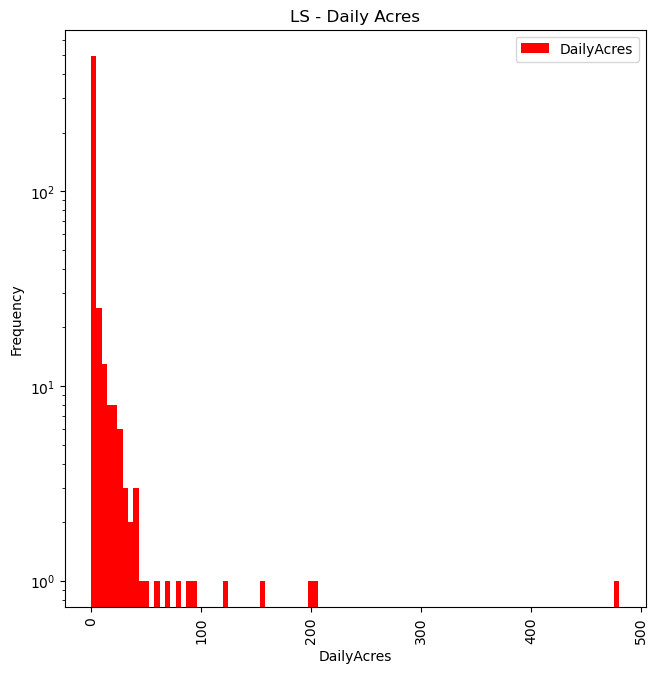

In [144]:
# Plot histogram of 'missed' (LS but not BRZ) fires as a function fo fire size [LS - DailyAcres]

print('\nMinimum missed LS fire size (Daily Acres):', gdf_LS_BRZ_no_intersection.DailyAcres.min())
print('\nMaximum missed LS fire size (Daily Acres):', gdf_LS_BRZ_no_intersection.DailyAcres.max())

data_no_intersection = gdf_LS_BRZ_no_intersection[['DailyAcres']]

print('\nNumber of missed fires per (DailyAcres) area:')
print(data_no_intersection['DailyAcres'].value_counts().sort_index())
print('\n')

data_no_intersection.plot(kind='hist', figsize=(7.5,7.5),bins=100, title = "LS - Daily Acres", color='red', logy=True)

plt.xticks(rotation=90)

plt.xlabel("DailyAcres")

plt.show()


Minimum missed LS fire size (Daily Acres > 100): 122.0

Maximum missed LS fire size (Daily Acres > 100): 480.0

Number of missed fires per (DailyAcres) area:
122.0    1
154.5    1
200.0    1
203.0    1
480.0    1
Name: DailyAcres, dtype: int64




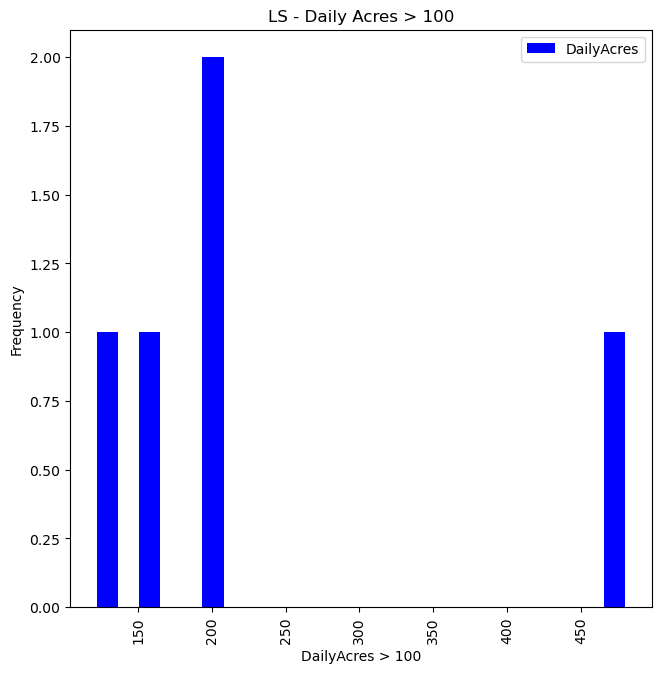

In [143]:
# Plot histogram of 'missed' (LS but not BRZ) fires as a function fo fire size [LS - DailyAcres] *** FIRES > 100 ACRES

gdf_LS_BRZ_no_intersection_above_100a = gdf_LS_BRZ_no_intersection.where(gdf_LS_BRZ_no_intersection['DailyAcres']>=100)

print('\nMinimum missed LS fire size (Daily Acres > 100):', gdf_LS_BRZ_no_intersection_above_100a.DailyAcres.min())
print('\nMaximum missed LS fire size (Daily Acres > 100):', gdf_LS_BRZ_no_intersection_above_100a.DailyAcres.max())

data_no_intersection_above_100a = gdf_LS_BRZ_no_intersection_above_100a[['DailyAcres']]

print('\nNumber of missed fires per (DailyAcres) area:')
print(data_no_intersection_above_100a['DailyAcres'].value_counts().sort_index())
print('\n')

data_no_intersection_above_100a.plot(kind='hist', figsize=(7.5,7.5),bins=25, title = "LS - Daily Acres > 100", color='blue', logy=False)

plt.xticks(rotation=90)

plt.xlabel("DailyAcres > 100")

plt.show()

AttributeError: 'NaturalEarthFeature' object has no attribute 'plot'

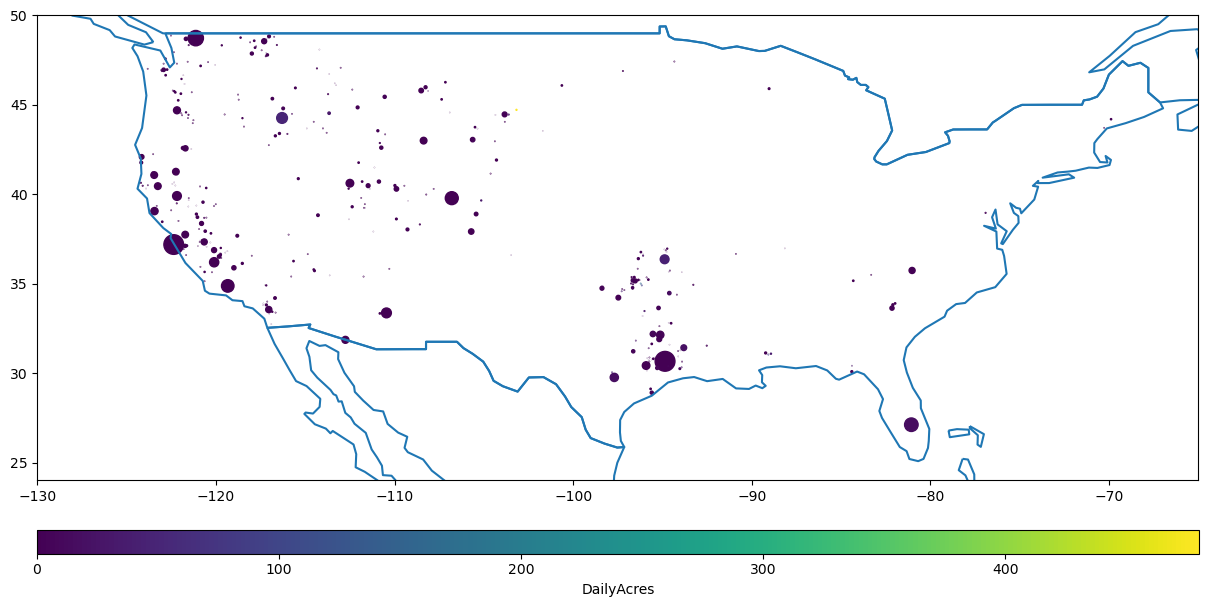

In [163]:
# Plot 'missing' fires with varying size according to 'DailyAcres' value

# Change geometry to 'centroid' column for display
gdf_tmp_no_BRZ_plot = gdf_LS_BRZ_no_intersection.copy()
gdf_tmp_no_BRZ__plot_centroid = gdf_tmp_no_BRZ_plot.set_geometry('centroid')

fig, ax = plt.subplots(1, 1, figsize=(15,15))

divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="5%", pad=0.5)

# set aspect to equal. This is done automatically when using *geopandas* plot on it's own, but not when working with pyplot directly.
ax.set_aspect('equal')

xlim = ([-130, -65])
ylim = ([24, 50])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

gdf_tmp_no_BRZ__plot_centroid.plot(kind='geo', column='DailyAcres', markersize=gdf_LS_BRZ_no_intersection['DailyAcres'], ax=ax, cax=cax,
                                legend=True, legend_kwds={'label': "DailyAcres", 'orientation': "horizontal"},
                                zorder=1)

world.boundary.plot(ax=ax, zorder=2)

LAND.plot(ax=ax, zorder=3)

plt.show();

In [46]:
# Choropleth EXPLORE map of 'missed' fires
# calculate number of missed fires compared to total fires per local source

# drop timestamp columns (as they are not JSON serializable and explore() is based on folium/leaflet.js and uses GeoJSON formated data) and explore GDF
gdf_tmp_no_BRZ = gdf_LS_BRZ_no_intersection.copy()
gdf_tmp_no_BRZ = gdf_tmp_no_BRZ.drop(['SourceLastUpdated', 'SourceDiscoveryDateTime', 'SourceCreatedOnDateTime', 'ts', 'CompareDateTime', 'minCompareDateTime', 'maxCompareDateTime'], axis=1)

# Change geometry to 'centroid' column for display
gdf_tmp_no_BRZ_centroid = gdf_tmp_no_BRZ.set_geometry('centroid')

m = gdf_tmp_no_BRZ_centroid.explore(
    column="DailyAcres",  # make choropleth based on "DailyAcres" column
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True, # show legend
    k=10, # use 10 bins
    legend_kwds=dict(colorbar=False), # do not use colorbar
    name="DailyAcres", # name of the layer in the map
    location=[39.5, -6], # centred on Portugal/Spain as a start location
    zoom_start=6, 
    tiles='openstreetmap', 
    popup=True, # input GeoDataFrame attributes for object displayed when clicking
    tooltip=False, # display GeoDataFrame attributes when hovering over the object.
    marker_kwds=dict(fill=True, radius=10)
    # marker_kwds=dict(fill=True, radius=lambda x: x['DailyAcres'])
)

# cities.explore(
     # m=m, # pass the map object
     # color="red", # use red color on all points
     # marker_kwds=dict(radius=10, fill=True), # make marker radius 10px with fill
     # tooltip="name", # show "name" column in the tooltip
     # tooltip_kwds=dict(labels=False), # do not show column label in the tooltip
     # name="cities" # name of the layer in the map
# )

# for _, r in gdf_tmp_no_BRZ.iterrows():
    # lat = r['centroid'].y
    # lon = r['centroid'].x
    # folium.Marker(location=[lat, lon],
                  # popup='<br> area: {}'.format(r['DailyAcres'])).add_to(m)

# add background map option and layer control to map
folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m  # show map


Minimum BRZ fire size (Calculated Acres): 103.5469607099379

Maximum BRZ fire size (Calculated Acres): 19468.418099354105

Number of missed fires per (CalculatedAcres) area:
103.546961      4
104.656907      1
105.817475      1
109.368005      1
109.885986      1
               ..
18054.047207    2
18054.047207    2
18136.685317    4
18168.655330    2
19468.418099    2
Name: CalculatedAcres, Length: 416, dtype: int64




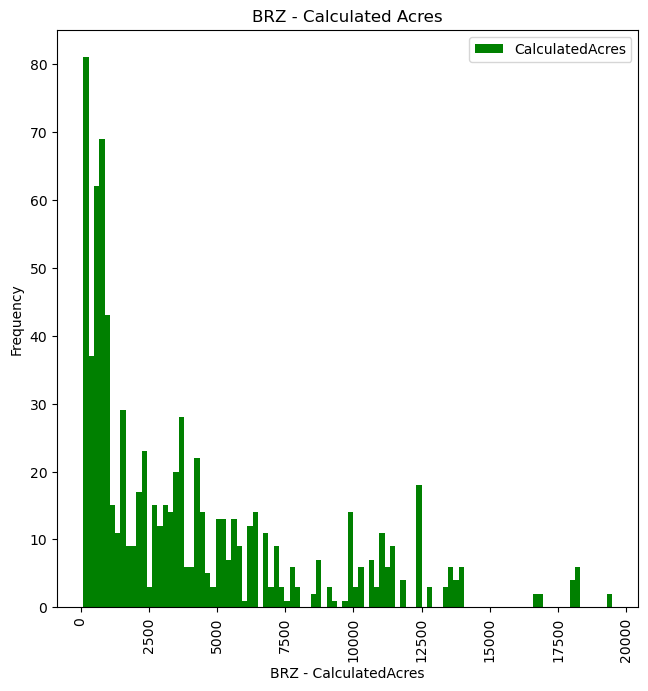

In [145]:
# Plot histogram of 'common' (LS and also BRZ) fires as a function fo fire size [BRZ - CalculatedAcres]

print('\nMinimum BRZ fire size (Calculated Acres):', gdf_LS_BRZ_intersection.CalculatedAcres.min())
print('\nMaximum BRZ fire size (Calculated Acres):', gdf_LS_BRZ_intersection.CalculatedAcres.max())

data_intersection = gdf_LS_BRZ_intersection[['CalculatedAcres']]

print('\nNumber of missed fires per (CalculatedAcres) area:')
print(data_intersection.CalculatedAcres.value_counts().sort_values(ascending=[False]).sort_index())
print('\n')

ax = data_intersection.plot(kind='hist', figsize=(7.5,7.5),bins=100, title = "BRZ - Calculated Acres", color='green')

plt.xticks(rotation=90)

plt.xlabel("BRZ - CalculatedAcres")

plt.show()